# Estimating covariance on SkySim5000 and using it on Gaussian likelihood

(derived from <a href='SkySim500_firstcheck.ipynb'>SkySim500_firstcheck</a> notebook)

Author : Michel Aguena

In [1]:
from IPython.display import Markdown
import numpy as np
import pyccl as ccl
import matplotlib.pyplot as plt
import scipy.integrate
import astropy.units as u
from astropy.table import Table
import GCRCatalogs

%matplotlib inline

In [2]:
skysim_cat = GCRCatalogs.load_catalog('skysim5000_v1.1.1_small')

In [3]:
cosmo_ss  = skysim_cat.cosmology
cosmo_ss

FlatLambdaCDM(H0=71 km / (Mpc s), Om0=0.265, Tcmb0=0 K, Neff=3.04, m_nu=None, Ob0=0.0448)

## Extract DM haloes from the catalog in a given mass and redshift range. 

In [4]:
%%time
# get list of halos in a given redshift and mass range
mmin_extract = 1.e12 # Msun (M_fof)
zmin_extract = 0.
zmax_extract = 1.0
dm_halos = Table(skysim_cat.get_quantities(['halo_mass','hostHaloMass','redshift','ra', 'dec', 'halo_id',
                                             'baseDC2/sod_halo_mass','baseDC2/sod_halo_radius'],
                                            filters=[f'halo_mass > {mmin_extract}','is_central==True',
                                            f'redshift>{zmin_extract}', f'redshift<{zmax_extract}']))
# NB: SkySim5000 M200c masses are in units of Msun/h
dm_halos['m200c'] = dm_halos['baseDC2/sod_halo_mass']/cosmo_ss.h

CPU times: user 3.54 s, sys: 8.41 s, total: 12 s
Wall time: 2min 35s


In [5]:
print(f'There are {len(dm_halos):,} halos in this mass (Mfof) and redshift range')

There are 300,879 halos in this mass (Mfof) and redshift range


Text(0, 0.5, 'dec [deg]')

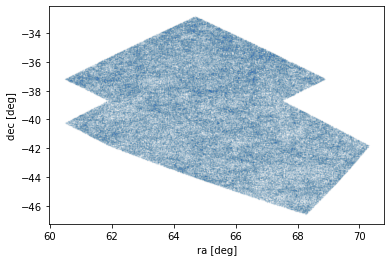

In [6]:
plt.scatter(dm_halos['ra'], dm_halos['dec'], marker='.', s=0.001)
plt.xlabel('ra [deg]')
plt.ylabel('dec [deg]')

## Define a redshift and mass range for the comparison of data and prediction, and filter the data accordingly

In [7]:
dm_halos = dm_halos[dm_halos['m200c']>1e13]
print(f'There are {len(dm_halos):,} halos with M200c > 1e13 Msun')

There are 22,252 halos with M200c > 1e13 Msun


In [8]:
# Define mass and redshift bins
n_mbins, n_zbins = 8, 5
nc_meas, logmass_bins, z_bins = np.histogram2d(
    np.log10(dm_halos['m200c']), dm_halos['redshift'],
    bins=(n_mbins, n_zbins))
mid_logmass = 0.5*(logmass_bins[:-1]+logmass_bins[1:])
mid_z = 0.5*(z_bins[:-1]+z_bins[1:])

In [9]:
mid_z, z_bins

(array([0.11919761, 0.31492483, 0.51065204, 0.70637926, 0.90210648]),
 array([0.021334  , 0.21706122, 0.41278844, 0.60851565, 0.80424287,
        0.99997009]))

In [10]:
logmass_bins

array([13.00010228, 13.2492496 , 13.49839692, 13.74754424, 13.99669156,
       14.24583888, 14.4949862 , 14.74413352, 14.99328084])

Plot number counts

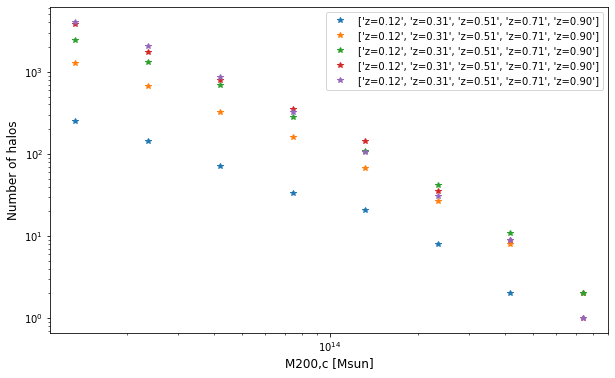

In [11]:
plt.figure(figsize=(10,6))
plt.plot(10**mid_logmass, nc_meas, marker='*', ls='', label=[f'z={z:.2f}' for z in mid_z])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('M200,c [Msun]', size=12)
plt.ylabel('Number of halos', size=12)
plt.legend()
#print(f"Total number of halos in z=[{zmin},{zmax}] and M=[{mmin/1.e14:.2f}, {mmax/1.e15}] x 1e15 Msun: {len(data):,}")

# Measure covariance of clusters

Add pixels and check outliers to define which will be used for covariance computation

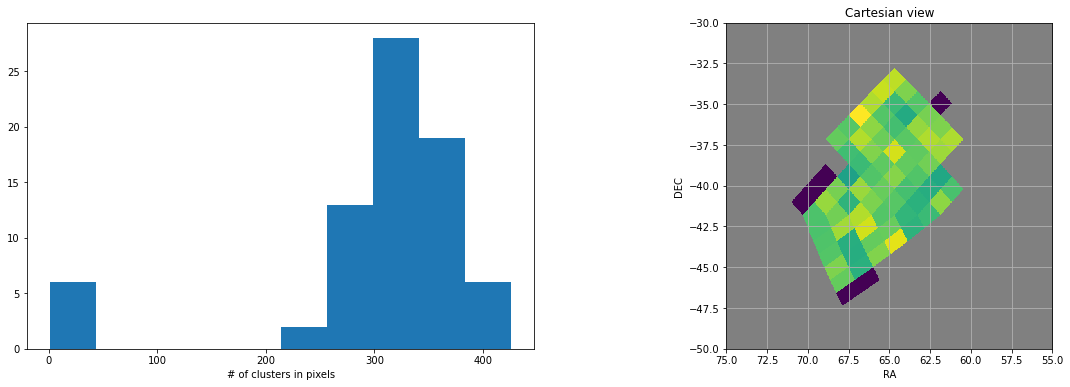

In [12]:
import healpy as hp

nside = 64
dm_halos['pixel'] = hp.ang2pix(nside, dm_halos['ra'], dm_halos['dec'], lonlat=True)


f, axes = plt.subplots(1, 2, figsize=(20, 6))
map_ = np.histogram(dm_halos['pixel'], np.arange(hp.nside2npix(nside)+1))[0]
map_ = np.array(map_, dtype=float)
map_[map_==0] = np.nan

#plot histogram of counts
axes[0].hist(map_)
axes[0].set_xlabel('# of clusters in pixels')

# plot map
hp.cartview(map_, latra=[-50, -30], lonra=[55, 75], 
            hold=True, cbar=False)

hp_ax = f.axes[-1]
hp_ax.axis('on')

#ax.patch.set_alpha(0.)
hp_ax.set_xlabel('RA')
hp_ax.set_ylabel('DEC')
hp_ax.grid(color='.7')
hp_ax.set_xticklabels(-hp_ax.get_xticks()) # RA values in plot are inverted


plt.show()

Define pixels to be used in covariance computation

In [13]:
pixels_for_cov = np.arange(hp.nside2npix(nside))[map_>200]

Bin the data in mass,redshift and pixels

In [14]:
pixeled_nc = np.transpose([
    np.histogram2d(
        np.log10(dm_halos['m200c'])[dm_halos['pixel']==p],
        dm_halos['redshift'][dm_halos['pixel']==p],
        bins=(logmass_bins, z_bins)
    )[0].flatten()
    for p in pixels_for_cov])

In [15]:
pixeled_nc = np.transpose([
    np.histogram2d(
        dm_halos['redshift'][dm_halos['pixel']==p],
        np.log10(dm_halos['m200c'])[dm_halos['pixel']==p],
        bins=(z_bins, logmass_bins)
    )[0].flatten()
    for p in pixels_for_cov])

Compute covariance and correlation matrices
\begin{equation}
Corr_{ij} = \frac{Cov_{ij}}{\sqrt{Cov_{ii}Cov_{jj}}}
\end{equation}

In [16]:
cov = np.cov(pixeled_nc)*(skysim_cat.sky_area/hp.nside2pixarea(nside, degrees=True))

In [17]:
corr = np.corrcoef(pixeled_nc)

See how strong correlated the different mass bins are:

### the larger squares are redshift bins and the small ones are mass bins:

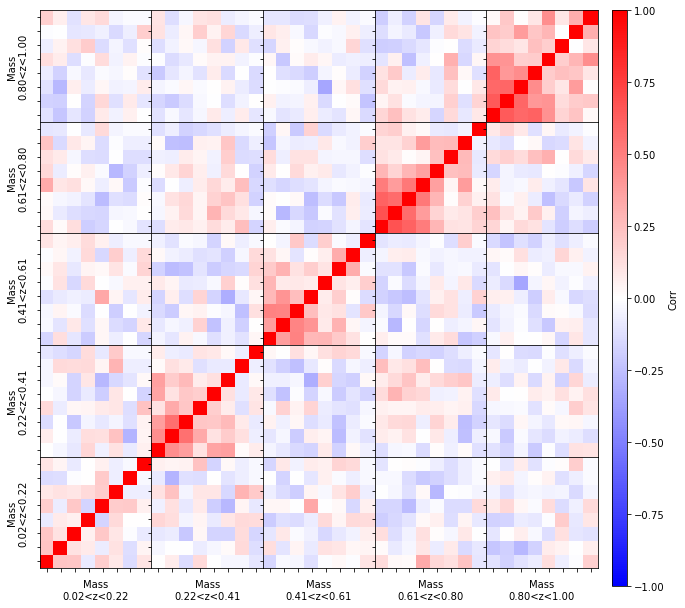

In [18]:
f, axes = plt.subplots(
    n_zbins, n_zbins, sharex=True, sharey=True,
    figsize=(10,10), gridspec_kw={'hspace': 0., 'wspace': 0.,
                                 'right':.9, 'top':.9})
for i in range(n_zbins):
    for j in range(n_zbins):
        colors = axes[::-1][i][j].pcolor(
            corr[n_mbins*i:n_mbins*(i+1), n_mbins*j:n_mbins*(j+1)],
            vmin=-1, vmax=1, cmap='bwr')
for ax, z1, z2 in zip(axes[-1], z_bins, z_bins[1:]):
    ax.set_xticklabels([])
    ax.set_xlabel(f'Mass\n{z1:.2f}<z<{z2:.2f}')
for ax, z1, z2 in zip(axes[::-1,0], z_bins, z_bins[1:]):
    ax.set_yticklabels([])
    ax.set_ylabel(f'Mass\n{z1:.2f}<z<{z2:.2f}')
for ax in axes.flatten():
    ax.set_xticks(np.arange(n_mbins)+.5)
    ax.set_yticks(np.arange(n_mbins)+.5)
cb_ax = plt.axes([.92, .1, .02, .8])
#colors = plt.pcolor(corr)
plt.colorbar(colors, cax=cb_ax, label='Corr')
#plt.xlabel('mass bin')
#plt.ylabel('mass bin')
Markdown('### the larger squares are redshift bins and the small ones are mass bins:')

Plot number counts with variance as errorbars

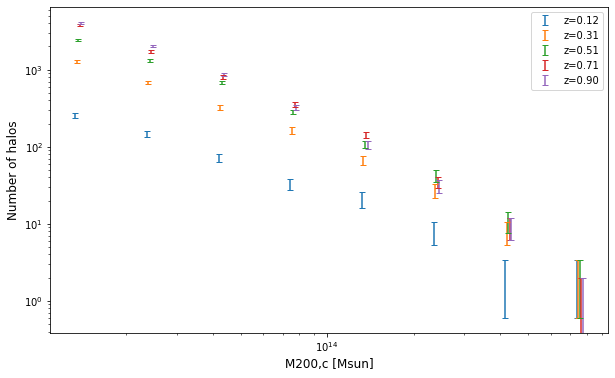

In [19]:
plt.figure(figsize=(10,6))
shift, i = .005, 0 # Add shift to see all points
i = 0
for nc, err, lab in zip(nc_meas.T, np.sqrt(np.diag(cov)).reshape(n_zbins, n_mbins),
                        [f'z={z:.2f}' for z in mid_z]):
    plt.errorbar(10**(mid_logmass+i*shift), nc, err, ls='', capsize=3, label=lab)
    i += 1
plt.xscale('log')
plt.yscale('log')
plt.xlabel('M200,c [Msun]', size=12)
plt.ylabel('Number of halos', size=12)
plt.legend()
#print(f"Total number of halos in z=[{zmin},{zmax}] and M=[{mmin/1.e14:.2f}, {mmax/1.e15}] x 1e15 Msun: {len(data):,}")

## Prediction using CCL and the Tinker08 and Bocquet16 mass functions

In [20]:
# Define CCL Cosmology from SkySim cosmology
cosmo = ccl.Cosmology(Omega_c=cosmo_ss.Om0-cosmo_ss.Ob0, Omega_b=cosmo_ss.Ob0,
                      h=cosmo_ss.h, sigma8=cosmo_ss.sigma8, n_s=cosmo_ss.n_s, Neff=3.04)

print(cosmo)


pyccl.Cosmology(Omega_c=0.21999999999999997, Omega_b=0.0448, h=0.71, n_s=0.963, sigma8=0.8, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.04, w0=-1.0, wa=0.0, T_CMB=None, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='boltzmann_camb', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')


### Differential comoving volume

In [21]:
def dV_over_dOmega_dz(z):
    a = 1./(1. + z)
    da = ccl.background.angular_diameter_distance(cosmo, a) 
    E = ccl.background.h_over_h0(cosmo, a)
    return ((1.+z)**2)*(da**2)*ccl.physical_constants.CLIGHT_HMPC/cosmo['h']/E 

In [22]:
### Sanity check - comparison to the volume computed with Astropy
dV_over_dOmega_dz(0.3), cosmo_ss.differential_comoving_volume(0.3).value 

(5181343866.521967, 5181928585.256843)

### CCL mass functions

In [23]:
hmd_200c = ccl.halos.MassDef(200, 'critical')
def tinker08(logm, z):
    mass = 10**(logm)
    hmf_200c = ccl.halos.MassFuncTinker08(cosmo, mass_def=hmd_200c)
    nm = hmf_200c.get_mass_function(cosmo, mass, 1./(1+z))
    return nm # dn/dlog10M

hmd_200c = ccl.halos.MassDef200c()
def bocquet16(logm, z):
    mass = 10**(logm)
    hmf_200c = ccl.halos.MassFuncBocquet16(cosmo, mass_def=hmd_200c)
    nm = hmf_200c.get_mass_function(cosmo, mass, 1./(1+z))
    return nm # dn/dlog10M

In [24]:
def integrand_tinker08(logm,z):
    return tinker08(logm, z)*dV_over_dOmega_dz(z)

def integrand_bocquet16(logm,z):
    return bocquet16(logm, z)*dV_over_dOmega_dz(z)

In [25]:
DeltaOmega = skysim_cat.sky_area * np.pi**2/180**2

In [26]:
%%time
# Loop over mass bins defined by plt.hist and predict the corresponding number of haloes
# for Tinker 08
N_predicted_T08 = np.array([[
        scipy.integrate.dblquad(
            integrand_tinker08, zmin, zmax, 
            lambda x:logmmin, lambda x:logmmax,
            epsabs=1.e-4, epsrel=1.e-4)[0]
        for zmin, zmax in zip(z_bins, z_bins[1:])]
    for logmmin, logmmax in zip(logmass_bins, logmass_bins[1:])
])

CPU times: user 14.2 s, sys: 15.1 ms, total: 14.2 s
Wall time: 10.5 s


In [27]:
%%time
# Loop over mass bins defined by plt.hist and predict the corresponding number of haloes
# for Bocquet 16
N_predicted_B16  = np.array([[
        scipy.integrate.dblquad(
            integrand_bocquet16, zmin, zmax, 
            lambda x:logmmin, lambda x:logmmax,
            epsabs=1.e-4, epsrel=1.e-4)[0]
        for zmin, zmax in zip(z_bins, z_bins[1:])]
    for logmmin, logmmax in zip(logmass_bins, logmass_bins[1:])
])

CPU times: user 1.35 s, sys: 2.97 ms, total: 1.35 s
Wall time: 1.35 s


## Plot measured versus predicted number of haloes

(10901201795026.336, 903459604495227.6, 0.0, 1.0)

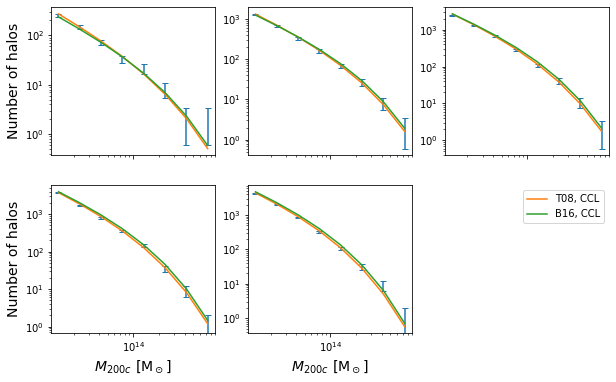

In [28]:
f, axes = plt.subplots(2, 3, figsize=(10,6), sharex=True)

for i in range(n_zbins):
    ax = axes.flatten()[i]
    ax.errorbar(
        10**mid_logmass, nc_meas[:,i],
        np.sqrt(np.diag(cov)).reshape(n_zbins, n_mbins)[i],
        ls='', capsize=3,
        label=f'SkySim5000, {skysim_cat.sky_area:.2f} deg2 field')
    ax.plot(10**mid_logmass, N_predicted_T08[:,i]*DeltaOmega, label='T08, CCL')
    ax.plot(10**mid_logmass, N_predicted_B16[:,i]*DeltaOmega, label='B16, CCL')
    ax.set_xscale('log')
    ax.set_yscale('log')
    #leg = ax.legend(fontsize=12)
    #ax.get_legend().remove()
for ax in axes[-1,:]:
    ax.set_xlabel('$M_{200c}$ [M$_\odot$]', size=14)
for ax in axes[:,0]:
    ax.set_ylabel('Number of halos', size=14)
    
leg_info = [l for l in axes[0][0].collections+axes[0][0].lines
            if l._label[0]!='_']
axes[-1][-1].legend(leg_info, [l._label for l in leg_info])
axes[-1][-1].axis('off')

# Gaussian likelihood

\begin{equation}
\mathcal{L} = \frac{1}{\sqrt{det(2\pi Cov)}}\exp{\left[-\frac{1}{2}(Obs-Theo)Cov^{-1}(Obs-Theo)^T\right]}
\end{equation}

In [29]:
def lnlike(obs, theo, cov):
    diff = obs-theo
    icov = np.linalg.inv(cov)
    chi2 = np.dot(diff, np.dot(icov, diff))
    return -0.5*chi2 - 0.5*np.log(np.linalg.det(cov))

In [30]:
lnlike_T08 = lnlike(nc_meas.flatten(), N_predicted_T08.flatten()*DeltaOmega, cov)
lnlike_B16 = lnlike(nc_meas.flatten(), N_predicted_B16.flatten()*DeltaOmega, cov)

lnlike_T08_diag = lnlike(nc_meas.flatten(), N_predicted_T08.flatten()*DeltaOmega, np.diag(np.diag(cov)))
lnlike_B16_diag = lnlike(nc_meas.flatten(), N_predicted_B16.flatten()*DeltaOmega, np.diag(np.diag(cov)))

Markdown(f'''
The value for $\log(\mathcal{{L}})$ for each case are:

| Mass function | Full covariance | Diagonal only |
|-|-|-|
| Tinker 2008 | {lnlike_T08:,.0f} | {lnlike_T08_diag:,.0f} |
| Bocquet 2016 | {lnlike_B16:,.0f} | {lnlike_B16_diag:,.0f} |

When the off diagonal elements of the covariance matrix are ignored,
we are implying the bins are not correlated (i. e. there is no information shared among different bins)
and the total information contained in the data is larger.
Therefore the likelihood with only the diagonal of the covariance is larger.
''')


The value for $\log(\mathcal{L})$ for each case are:

| Mass function | Full covariance | Diagonal only |
|-|-|-|
| Tinker 2008 | -5,643 | -3,151 |
| Bocquet 2016 | -37,763 | -14,243 |

When the off diagonal elements of the covariance matrix are ignored,
we are implying the bins are not correlated (i. e. there is no information shared among different bins)
and the total information contained in the data is larger.
Therefore the likelihood with only the diagonal of the covariance is larger.
